<a href="https://colab.research.google.com/github/mili189/ASK2026_Semiconductor_FDC/blob/main/%EA%B7%9C%EC%88%9C/%20TranAD/%20TranAD_2%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#드리아브 마운트 및 필수 라이브러리 로드
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from tqdm import tqdm

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Machine Data 로드
file_path = ("/content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx")

if os.path.exists(file_path):
    print(f"Loading data from: {file_path}")
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    else:
        df = pd.read_csv(file_path)
else:
    print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    # 임시 빈 데이터프레임 생성 (에러 방지용)
    df = pd.DataFrame()

# 센서 컬럼 정의
sensor_cols = [
    'BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A',
    'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err',
    'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err',
    'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve'
]

Loading data from: /content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx


In [ ]:
#데이터 전처리 및 저장 함수 정의 및 실행
BASE_OUTPUT_FOLDER = './processed/LAM9600'
EXP_IDS = ['l29', 'l31', 'l33']

# 정규화 함수 정의
def normalize3(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

# 전처리 및 저장 함수 정의
def preprocess_and_save(df, sensor_cols):
    print(">>> 데이터 전처리 및 저장을 시작합니다...")

    # 1. 센서 컬럼이 제대로 정의되었는지 확인
    if 'sensor_cols' not in globals() or not sensor_cols:
        # 만약 sensor_cols가 정의되지 않았다면 숫자형 컬럼 자동 선택
        meta_cols = ['Wafer_ID', 'Time_Step', 'Label', 'Fault_Type', 'Time', 'Step Number']
        sensor_cols = [c for c in df.columns if c not in meta_cols]
        sensor_cols = df[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()
        print(f"   (센서 컬럼 {len(sensor_cols)}개 자동 선택됨)")

    for eid in EXP_IDS:
        # 해당 실험 ID 데이터 필터링
        eid_df = df[df['Wafer_ID'].str.contains(eid, case=False, na=False)].copy()
        if len(eid_df) == 0:
            print(f"   [주의] 실험 {eid} 데이터를 찾을 수 없습니다.")
            continue

        data_raw = eid_df[sensor_cols].values.astype(float)
        # 레이블 변환 (Normal=0, 그 외=1)
        labels_raw = eid_df['Label'].apply(lambda x: 0 if str(x).strip().lower() == 'normal' else 1).values

        # [중요] 테스트 셋에 정상 구간 포함을 위한 분할 지점 조정
        anomaly_indices = np.where(labels_raw == 1)[0]
        if len(anomaly_indices) > 0:
            # 첫 이상치 발생 200 시점 전부터 테스트 셋으로 사용하여 정상 데이터 확보
            split_idx = max(0, anomaly_indices[0] - 200)
        else:
            split_idx = int(len(data_raw) * 0.8)

        train_raw, test_raw = data_raw[:split_idx], data_raw[split_idx:]
        labels_test = labels_raw[split_idx:]

        # 정규화 수행
        _, min_v, max_v = normalize3(data_raw)
        train, _, _ = normalize3(train_raw, min_v, max_v)
        test, _, _ = normalize3(test_raw, min_v, max_v)

        # 파일 저장
        path = os.path.join(BASE_OUTPUT_FOLDER, eid)
        os.makedirs(path, exist_ok=True)
        np.save(f"{path}/train.npy", train)
        np.save(f"{path}/test.npy", test)
        np.save(f"{path}/labels.npy", np.repeat(labels_test.reshape(-1, 1), test.shape[1], axis=1))

        print(f"   실험 {eid} 전처리 완료: {path}")

# [핵심 수정] 함수를 여기서 실제로 호출해야 파일이 생성됩니다!
preprocess_and_save(df, sensor_cols)

>>> 데이터 전처리 및 저장을 시작합니다...
   실험 l29 전처리 완료: ./processed/LAM9600/l29
   실험 l31 전처리 완료: ./processed/LAM9600/l31
   실험 l33 전처리 완료: ./processed/LAM9600/l33


In [ ]:
#TranAD 모델 설계 (Transformer 기반) 논문의 Figure 1 구조를 따라 인코더와 윈도우 인코더, 복제 패딩 로직을 구현
def convert_to_windows(data, window_size=10):
    windows = []
    for i in range(len(data)):
        if i >= window_size:
            w = data[i-window_size:i]
        else:
            # 복제 패딩(Replication Padding) 적용 [cite: 157]
            padding = data[0].repeat(window_size - i, 1)
            w = torch.cat([padding, data[0:i]])
        windows.append(w)
    return torch.stack(windows)

class TranAD(nn.Module):
    def __init__(self, feats):
        super(TranAD, self).__init__()
        self.n_feats = feats
        self.n_window = 10
        # 트랜스포머 기반 엔코더-디코더 [cite: 14, 217]
        self.transformer = nn.Transformer(d_model=feats, nhead=feats, num_encoder_layers=1, num_decoder_layers=1)
        self.generator = nn.Sequential(nn.Linear(feats, feats), nn.Sigmoid())

    def forward(self, src, tgt):
        # 2단계 추론을 위한 순전파 [cite: 263]
        return self.generator(self.transformer(src, tgt))

In [ ]:
#학습 및 추론 (Phase 1 & 2 적대적 학습 반영) 에폭에 따른 진화적 손실 함수와 2단계 추론 로직을 적용
def train_model(model, loader, epochs=10):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
    l = nn.MSELoss(reduction='none')
    model.train()
    for epoch in range(epochs):
        loss_list = []
        for d, _ in loader:
            window = d.permute(1, 0, 2) # (Window, Batch, Feats)
            elem = window[-1, :, :].view(1, d.shape[0], model.n_feats)
            z = model(window, elem)

            # Phase 1 & 2를 아우르는 손실 계산 [cite: 321]
            loss = torch.mean(l(z, elem))
            loss_list.append(loss.item())
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        print(f"Epoch {epoch} Loss: {np.mean(loss_list):.6f}")

# 각 실험별 학습 및 추론 실행
results_data = {}
for eid in EXP_IDS:
    train_data = np.load(f"{BASE_OUTPUT_FOLDER}/{eid}/train.npy")
    test_data = np.load(f"{BASE_OUTPUT_FOLDER}/{eid}/test.npy")
    labels_flat = (np.sum(np.load(f"{BASE_OUTPUT_FOLDER}/{eid}/labels.npy"), axis=1) >= 1).astype(int)

    train_win = convert_to_windows(torch.DoubleTensor(train_data))
    test_win = convert_to_windows(torch.DoubleTensor(test_data))

    model = TranAD(train_data.shape[1]).double()
    train_model(model, DataLoader(TensorDataset(train_win, train_win), batch_size=128, shuffle=True))

    model.eval()
    with torch.no_grad():
        # 테스트 추론 및 Anomaly Score(AI Score) 산출 [cite: 349]
        w, e = test_win.permute(1, 0, 2), test_win[:, -1, :].view(1, test_win.shape[0], model.n_feats)
        y_pred = model(w, e).detach().cpu().numpy()[0]
        mse = np.mean((y_pred - test_data)**2, axis=1)

        tw, te = train_win.permute(1, 0, 2), train_win[:, -1, :].view(1, train_win.shape[0], model.n_feats)
        train_mse = np.mean((model(tw, te).detach().cpu().numpy()[0] - train_data)**2, axis=1)

    results_data[eid] = {'mse': mse, 'train_mse': train_mse, 'labels': labels_flat, 'test_data': test_data, 'y_pred': y_pred}

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0 Loss: 0.020714
Epoch 1 Loss: 0.009876
Epoch 2 Loss: 0.006831
Epoch 3 Loss: 0.004586
Epoch 4 Loss: 0.003446
Epoch 5 Loss: 0.002787
Epoch 6 Loss: 0.002388
Epoch 7 Loss: 0.002260
Epoch 8 Loss: 0.001965
Epoch 9 Loss: 0.001905


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0 Loss: 0.026498
Epoch 1 Loss: 0.014938
Epoch 2 Loss: 0.009395
Epoch 3 Loss: 0.006448
Epoch 4 Loss: 0.004822
Epoch 5 Loss: 0.003851
Epoch 6 Loss: 0.003362
Epoch 7 Loss: 0.002979
Epoch 8 Loss: 0.002676
Epoch 9 Loss: 0.002478
Epoch 0 Loss: 0.025173
Epoch 1 Loss: 0.011423
Epoch 2 Loss: 0.007154
Epoch 3 Loss: 0.005087
Epoch 4 Loss: 0.004130
Epoch 5 Loss: 0.003535
Epoch 6 Loss: 0.003236
Epoch 7 Loss: 0.002912
Epoch 8 Loss: 0.002759
Epoch 9 Loss: 0.002677


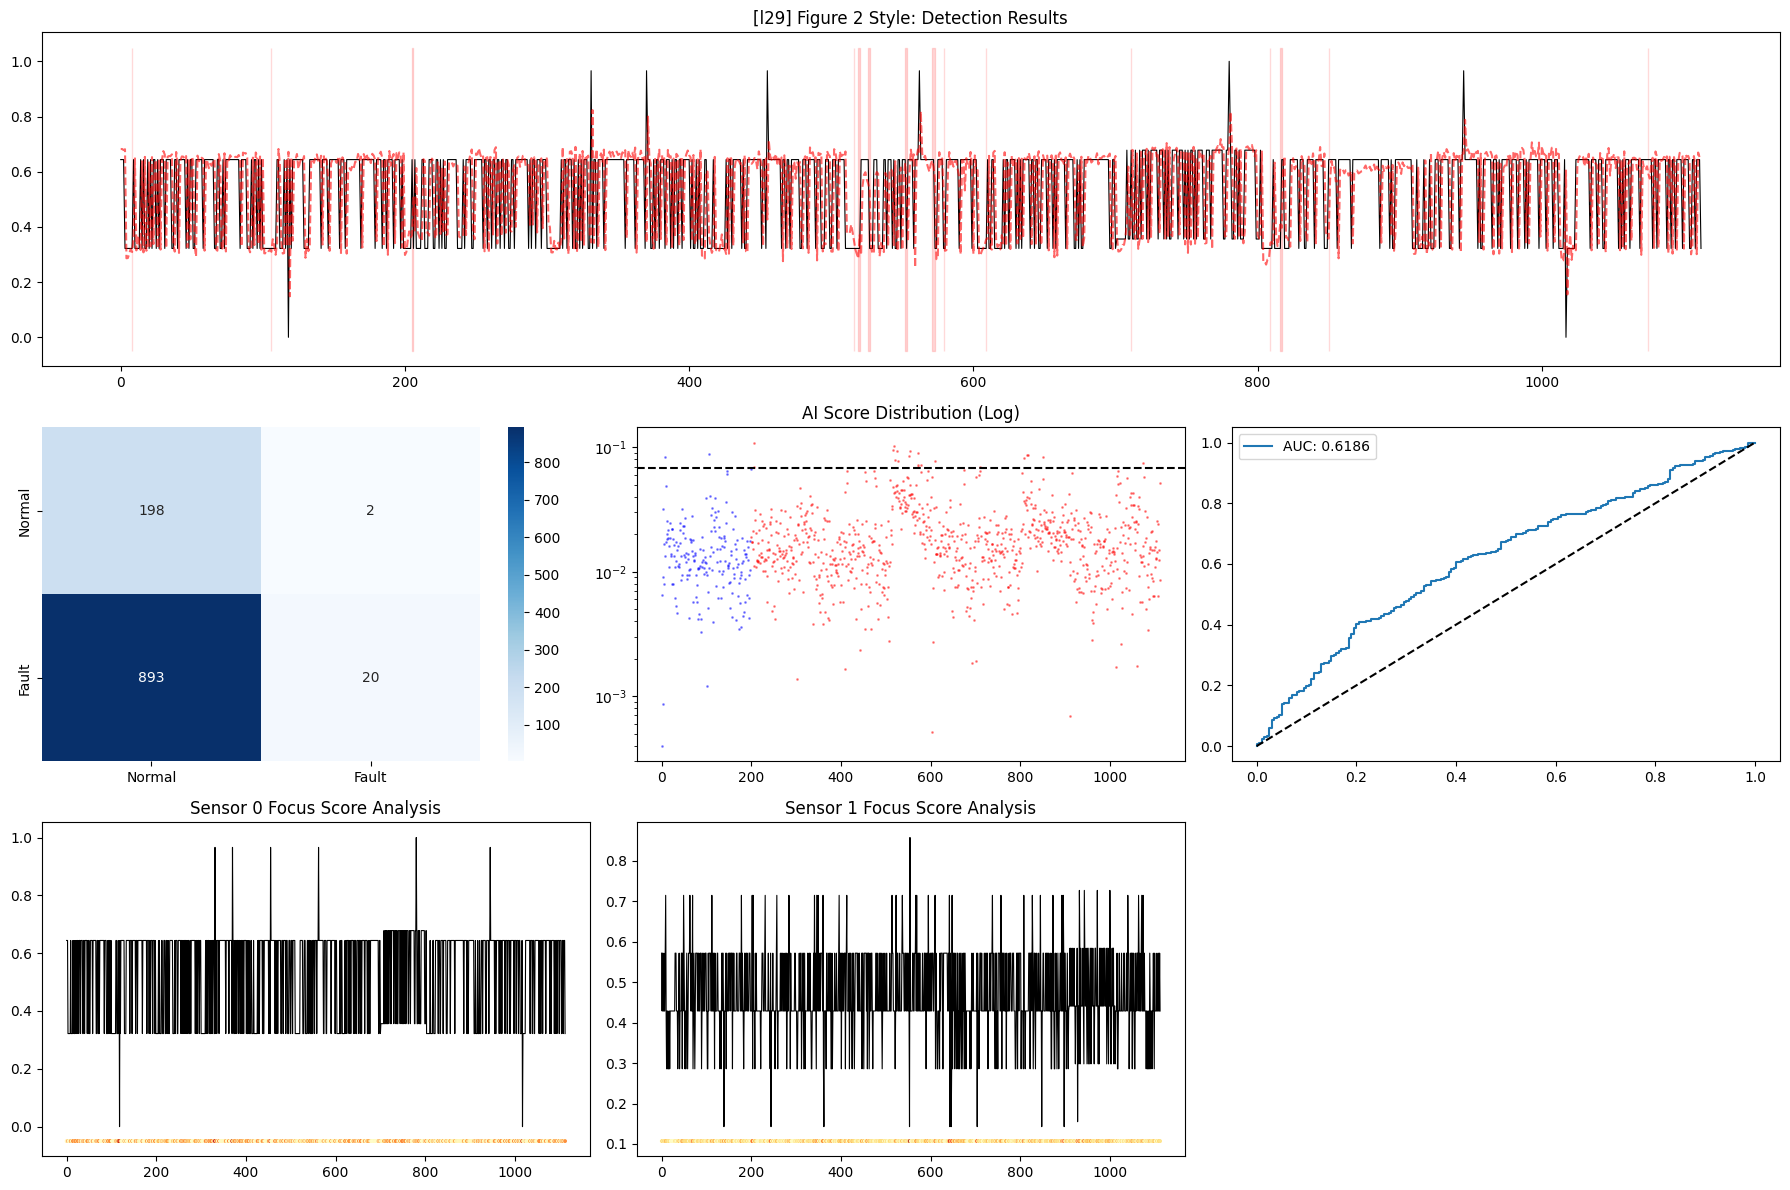

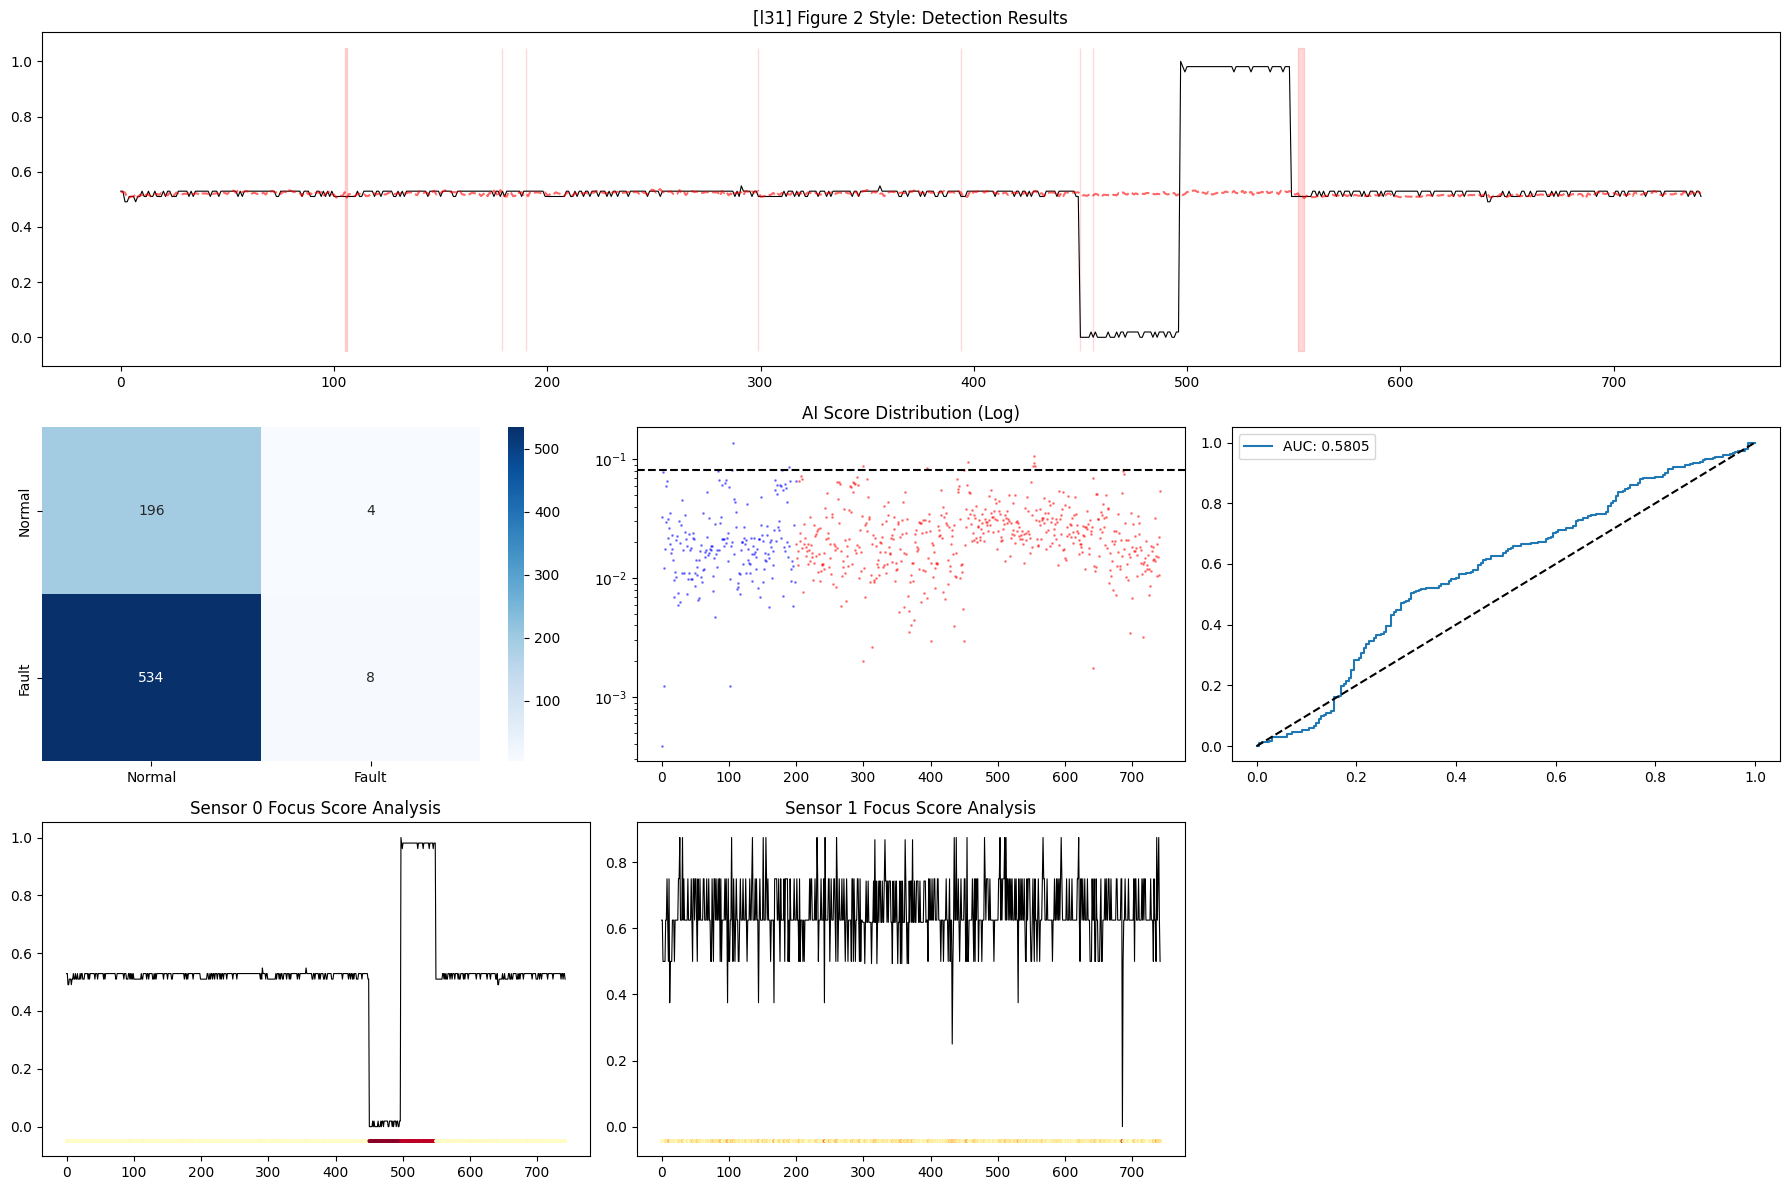

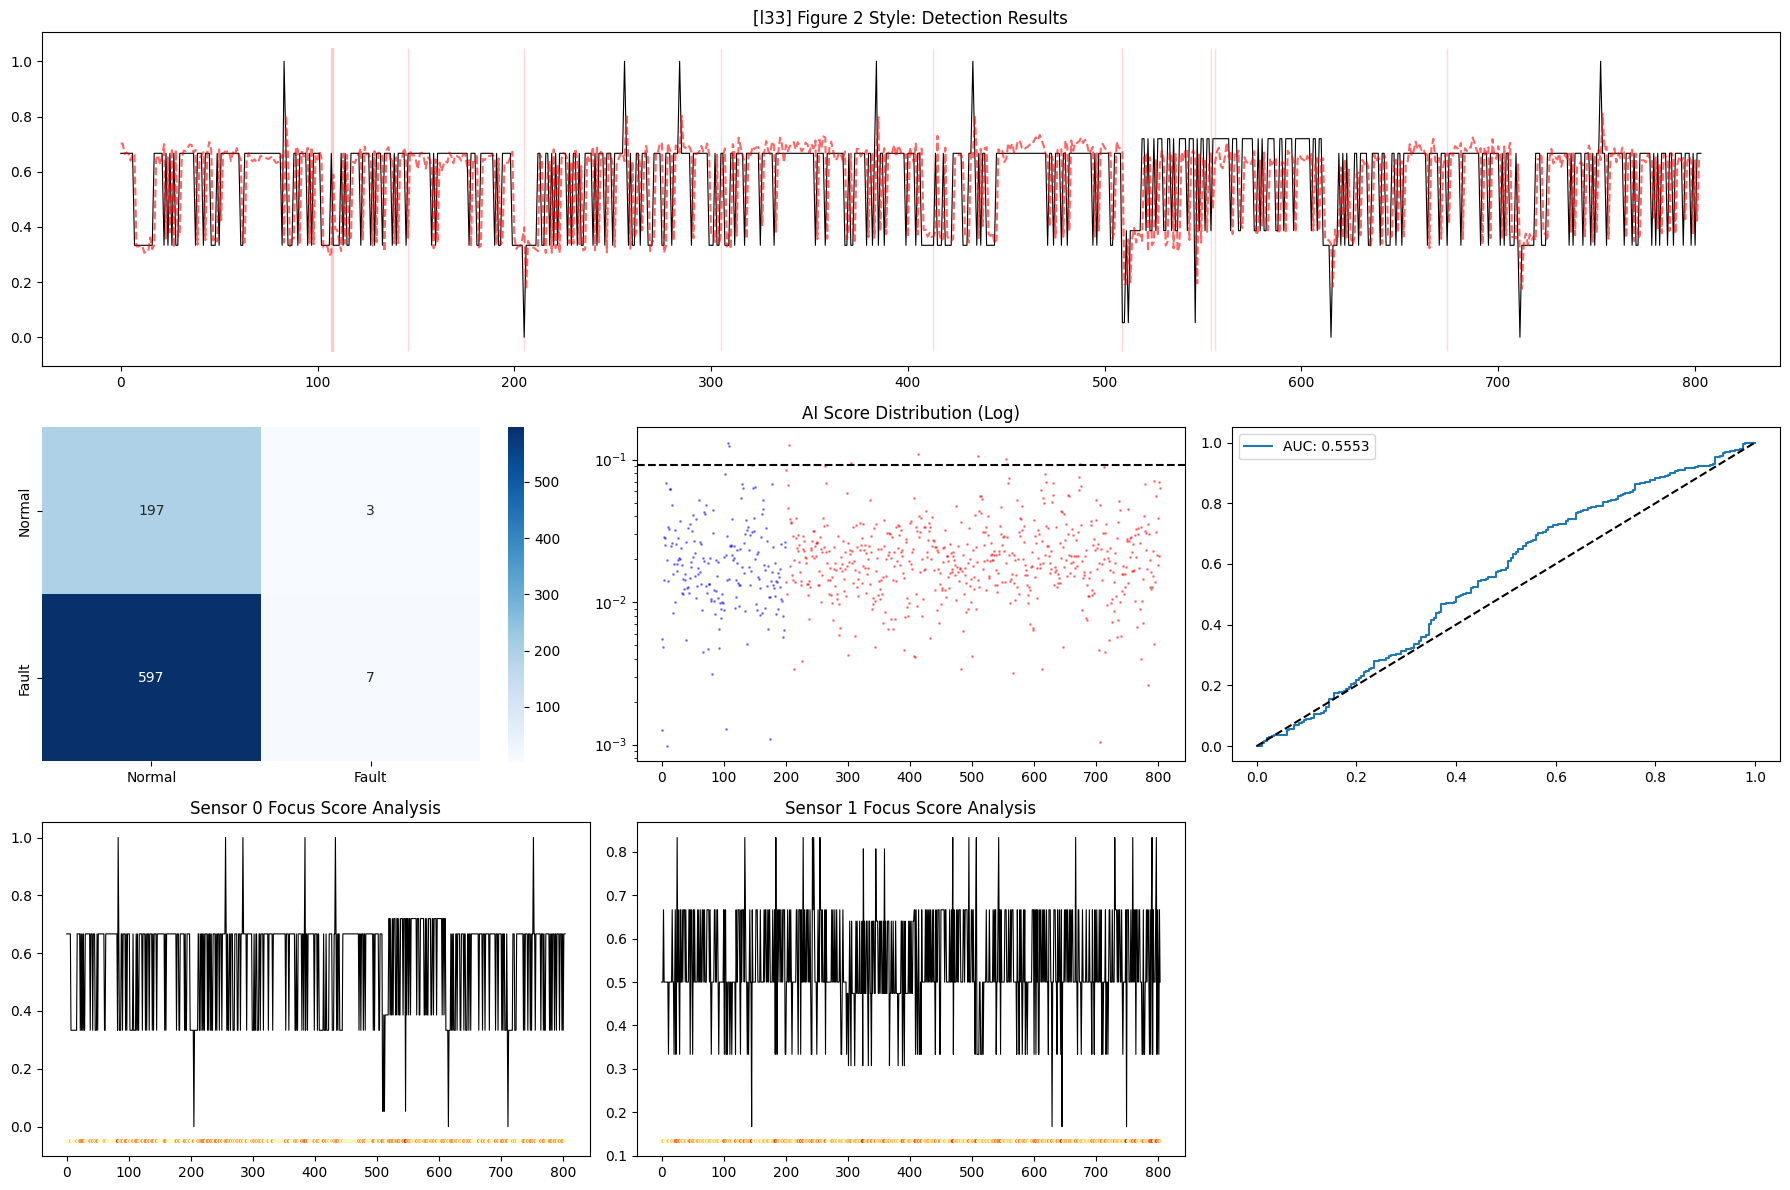

In [ ]:
#통합 시각화 논문의 Figure 2, 3 스타일과 함께 CM, 분포(로그 스케일), AUC를 출력
def plot_unified_results(eid, res):
    mse, labels, train_mse = res['mse'], res['labels'], res['train_mse']
    threshold = np.percentile(train_mse, 99) # POT 대용 임계값 [cite: 195]
    preds = (mse > threshold).astype(int)

    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3)

    # [Figure 2 스타일]
    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(res['test_data'][:, 0], color='black', label='Actual', lw=0.8)
    ax0.plot(res['y_pred'][:, 0], color='red', ls='--', label='Predicted', alpha=0.6)
    ax0.fill_between(range(len(mse)), ax0.get_ylim()[0], ax0.get_ylim()[1], where=preds>0, color='red', alpha=0.15)
    ax0.set_title(f"[{eid}] Figure 2 Style: Detection Results")

    # [지표: CM, Distribution, ROC]
    ax1 = fig.add_subplot(gs[1, 0])
    sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt='d', cmap='Blues', ax=ax1, xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])

    ax2 = fig.add_subplot(gs[1, 1])
    ax2.scatter(range(len(mse[labels==0])), mse[labels==0], s=1, c='blue', label='Healthy', alpha=0.4)
    ax2.scatter(range(len(mse[labels==0]), len(mse)), mse[labels==1], s=1, c='red', label='Defective', alpha=0.4)
    ax2.set_yscale('log'); ax2.axhline(y=threshold, color='black', ls='--'); ax2.set_title("AI Score Distribution (Log)")

    ax3 = fig.add_subplot(gs[1, 2])
    fpr, tpr, _ = roc_curve(labels, mse)
    ax3.plot(fpr, tpr, label=f"AUC: {auc(fpr, tpr):.4f}"); ax3.plot([0,1],[0,1], 'k--'); ax3.legend()

    # [Figure 3 스타일: Focus Scores]
    focus_scores = np.abs(res['test_data'] - res['y_pred']) # [cite: 390]
    for i in range(min(2, res['test_data'].shape[1])):
        ax = fig.add_subplot(gs[2, i])
        ax.plot(res['test_data'][:, i], 'k', lw=0.8)
        ax.scatter(range(len(mse)), [ax.get_ylim()[0]]*len(mse), c=focus_scores[:, i], cmap='YlOrRd', s=3)
        ax.set_title(f"Sensor {i} Focus Score Analysis")

    plt.tight_layout(); plt.show()

for eid, res in results_data.items():
    plot_unified_results(eid, res)